# PET Challenge 2025 - Zero-Shot Prediction Pipeline

**Challenge**: [ALIGN Bio PET Challenge 2025](https://data.alignbio.org/tournament/predictive-phase), Zero-Shot Track  
**Goal**: Predict PETase enzyme **activity** and **expression** for 4988 variant sequences without training data  
**Metric**: NDCG (Normalized Discounted Cumulative Gain) - ranking quality  
**Targets**:
- `activity_1`, `activity_2`: specific activity (μmol TPA/min·mg enzyme) at pH 5.5 and pH 9.0
- `expression`: soluble expression level (mg/mL) in *E. coli* BL21(DE3)

## Approach

We use **protein language models (PLMs)** for zero-shot variant effect prediction:

| Model | Parameters | Package | Method |
|-------|-----------|---------|--------|
| ESM2-650M | 650M | `fair-esm` | WT-marginal scoring (Meier et al. 2021) |
| ESMC-600M | 600M | `esm` (EvolutionaryScale) | WT-marginal scoring |

Plus **ML baselines** (Ridge, RF, XGBoost) validated against 12 verified IsPETase Tm values from literature.

### Key References
- **Meier et al. (2021)** NeurIPS - WT-marginal scoring method for variant effects  
- **Lin et al. (2023)** Science - ESM2 language models  
- **EvolutionaryScale (2024)** - ESMC (ESM Cambrian)  
- **Král (2025)** MSc Thesis, Charles University - PLM score combination for thermostability  
- **Brott et al. (2022)** Eng. Life Sci. - IsPETase Tm measurements (nanoDSF)  
- **Lu et al. (2022)** Nature - FAST-PETase (ML-designed)


---
## 1. Setup & Environment

**Important**: Select **GPU runtime** in Colab: Runtime → Change runtime type → T4 GPU

We install `fair-esm` (for ESM2) and `esm` (for ESMC) in sequence because they share the `esm` Python namespace.  
ESM2 scoring runs first with `fair-esm`, then we install the EvolutionaryScale `esm` package for ESMC.

In [1]:
# Core dependencies (always needed)
# For exact reproducibility, use requirements.txt with pinned versions:
# !pip install -r requirements.txt
# Below installs latest compatible versions:
!pip install -q numpy pandas scipy scikit-learn xgboost matplotlib seaborn joblib

import torch
import os
import sys

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  NO GPU DETECTED - Go to Runtime → Change runtime type → T4 GPU")
    print("    CPU-only will be very slow (~1 hour instead of ~5 minutes)")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
VRAM: 42.4 GB


In [2]:
# Set project root - handles Colab's /content/ path automatically
# If running from within the cloned repo:
if os.path.exists('data/petase_challenge_data'):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists('pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)
elif os.path.exists('/content/pet-challenge-2025/data/petase_challenge_data'):
    # Google Colab default clone location
    PROJECT_ROOT = '/content/pet-challenge-2025'
    os.chdir(PROJECT_ROOT)
else:
    # Clone the repo
    !git clone https://github.com/fulopjoz/pet-challenge-2025.git
    # Pin to specific commit for reproducibility:
    # !git checkout <COMMIT_HASH>  # fill in after final commit
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Working dir:  {os.getcwd()}")

# Verify ALL required files exist
required_files = [
    'data/petase_challenge_data/pet-2025-wildtype-cds.csv',
    'data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv',
    'data/mutations_dataset.csv',
    'data/features_matrix.csv',
    'scripts/esm2_zero_shot_scoring.py',
    'scripts/esmc_scoring.py',
    'scripts/compute_cds_features.py',
    'scripts/generate_submission.py',
    'scripts/generate_submission_v2.py',
    'scripts/validate_scores.py',
]
all_ok = True
for f in required_files:
    path = os.path.join(PROJECT_ROOT, f)
    if os.path.exists(path):
        size_kb = os.path.getsize(path) / 1024
        print(f"  OK: {f} ({size_kb:.0f} KB)")
    else:
        print(f"  MISSING: {f}")
        all_ok = False

if all_ok:
    print("\nAll files present!")
else:
    print("\nSome files missing - check your clone or upload")

# Make results directory
os.makedirs(os.path.join(PROJECT_ROOT, 'results'), exist_ok=True)

Cloning into 'pet-challenge-2025'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 134 (delta 61), reused 109 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 2.51 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Project root: /content/pet-challenge-2025
Working dir:  /content/pet-challenge-2025
  OK: data/petase_challenge_data/pet-2025-wildtype-cds.csv (302 KB)
  OK: data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv (1274 KB)
  OK: data/mutations_dataset.csv (2 KB)
  OK: data/features_matrix.csv (7 KB)
  OK: scripts/esm2_zero_shot_scoring.py (14 KB)
  OK: scripts/esmc_scoring.py (14 KB)
  OK: scripts/compute_cds_features.py (11 KB)
  OK: scripts/generate_submission.py (9 KB)
  OK: scripts/generate_submission_v2.py (18 KB)
  OK: scripts/validate_scores.py (13 KB)

All files present!


---
## 2. Data Exploration

The challenge provides:
- **313 wild-type PETase sequences** (diverse scaffolds, lengths 183-266 aa)
- **4988 test sequences** to predict: 314 WT-identical + 4674 single-point mutants
- **Expression system**: pET28a vector, BL21(DE3), IMAC purification, 6xHis tag
- **Activity assay**: Powdered PET substrate, 30°C, mass spec detection of TPA
  - `activity_1`: pH 5.5 (citrate buffer)
  - `activity_2`: pH 9.0 (glycine-NaOH buffer)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Load data
wt_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data/petase_challenge_data/pet-2025-wildtype-cds.csv'))
test_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv'))

print(f"Wild-type sequences: {len(wt_df)}")
print(f"Test sequences: {len(test_df)}")
print(f"\nWT columns: {list(wt_df.columns)}")
print(f"Test columns: {list(test_df.columns)}")

Wild-type sequences: 313
Test sequences: 4988

WT columns: ['Wt AA Sequence', 'CDS']
Test columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']


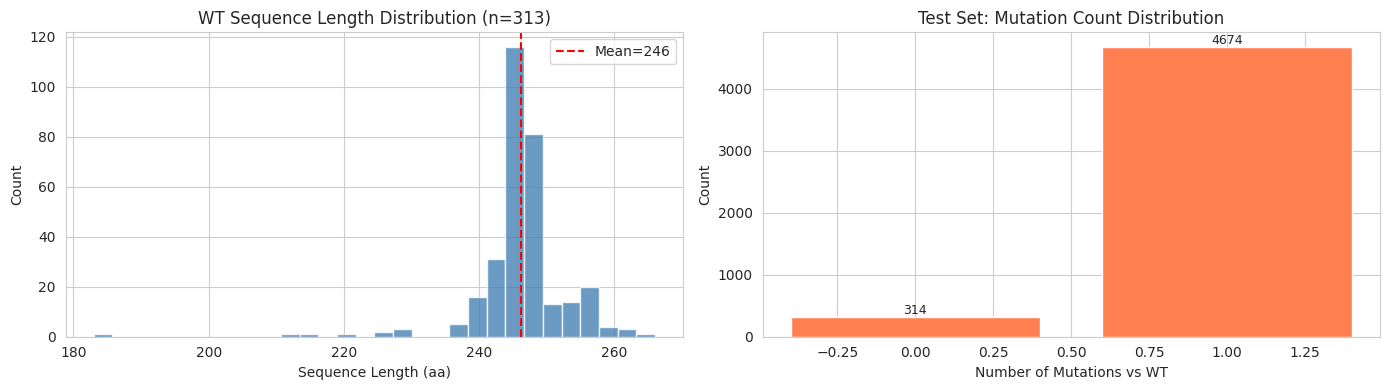


WT-identical: 314 (6.3%)
Single mutants: 4674 (93.7%)


In [4]:
# Analyze WT sequence diversity
wt_seqs = list(wt_df['Wt AA Sequence'].values)
wt_lengths = [len(s) for s in wt_seqs]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# WT length distribution
axes[0].hist(wt_lengths, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Sequence Length (aa)')
axes[0].set_ylabel('Count')
axes[0].set_title(f'WT Sequence Length Distribution (n={len(wt_seqs)})')
axes[0].axvline(np.mean(wt_lengths), color='red', ls='--', label=f'Mean={np.mean(wt_lengths):.0f}')
axes[0].legend()

# Map test sequences to WTs and count mutations
wt_by_len = defaultdict(list)
for i, seq in enumerate(wt_seqs):
    wt_by_len[len(seq)].append((i, seq))

test_n_muts = []
test_wt_idx = []
for test_seq in test_df['sequence'].values:
    tlen = len(test_seq)
    best_wt, best_diff = None, 999
    for wi, wseq in wt_by_len.get(tlen, []):
        ndiff = sum(1 for a, b in zip(wseq, test_seq) if a != b)
        if ndiff < best_diff:
            best_diff = ndiff
            best_wt = wi
        if ndiff == 0:
            break
    test_n_muts.append(best_diff)
    test_wt_idx.append(best_wt)

# Mutation count distribution
mut_counts = Counter(test_n_muts)
axes[1].bar(mut_counts.keys(), mut_counts.values(), color='coral', edgecolor='white')
axes[1].set_xlabel('Number of Mutations vs WT')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Set: Mutation Count Distribution')
for k, v in sorted(mut_counts.items()):
    axes[1].text(k, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nWT-identical: {mut_counts[0]} ({mut_counts[0]/len(test_df)*100:.1f}%)")
print(f"Single mutants: {mut_counts.get(1,0)} ({mut_counts.get(1,0)/len(test_df)*100:.1f}%)")

In [5]:
# Which WTs have the most variants?
wt_variant_counts = Counter(test_wt_idx)
top_wts = wt_variant_counts.most_common(10)

print("Top 10 WT scaffolds by number of test variants:")
print(f"{'WT Index':<10} {'Variants':<10} {'Length':<10} {'% of Test Set':<15}")
print("-" * 45)
for wi, count in top_wts:
    print(f"{wi:<10} {count:<10} {len(wt_seqs[wi]):<10} {count/len(test_df)*100:.1f}%")

# The 3 main scaffolds cover almost all variants
top3_total = sum(c for _, c in top_wts[:3])
print(f"\nTop 3 scaffolds cover {top3_total}/{len(test_df)} ({top3_total/len(test_df)*100:.1f}%) of test set")

Top 10 WT scaffolds by number of test variants:
WT Index   Variants   Length     % of Test Set  
---------------------------------------------
0          1560       259        31.3%
1          1559       257        31.3%
2          1559       259        31.3%
3          1          245        0.0%
4          1          242        0.0%
5          1          249        0.0%
6          1          245        0.0%
7          1          242        0.0%
8          1          244        0.0%
9          1          245        0.0%

Top 3 scaffolds cover 4678/4988 (93.8%) of test set


---
## 3. Approach 1: ESM2-650M Zero-Shot Scoring

### Method: Wildtype-Marginal Scoring

For each WT, we run a **single forward pass** through ESM2 and extract the predicted probability distribution at every position. For a mutation at position *i* from amino acid *w* to *m*:

$$\Delta LL = \log P(m | \text{context}) - \log P(w | \text{context})$$

This captures how "tolerated" the mutation is according to the model's evolutionary knowledge.  
Positive $\Delta LL$ = mutation is preferred over wildtype (rare, ~0.8% of mutations).  
Negative $\Delta LL$ = mutation is deleterious (common, ~99.2%).

We also compute auxiliary scores per Král A.(2025):
- **abs_ll**: mean log P(native aa): absolute sequence fitness
- **entropy**: mean positional entropy: lower = more conserved positions
- **logit_native**: mean raw logit for native residue: model confidence
- **joint_ll**: joint log-likelihood over all standard AAs

**Why ESM2-650M?** Top performer on [ProteinGym](https://proteingym.org/) zero-shot benchmarks.  
650M parameters, 33 layers, trained on 250M protein sequences (UniRef50).

In [6]:
# Install fair-esm for ESM2
!pip install -q fair-esm

# Verify import
import importlib
if 'esm' in sys.modules:
    del sys.modules['esm']
import esm
print(f"ESM package loaded: {esm.__file__}")
print(f"ESM2-650M available: {hasattr(esm.pretrained, 'esm2_t33_650M_UR50D')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.9 MB/s eta 0:00:00
ESM package loaded: /usr/local/lib/python3.12/dist-packages/esm/__init__.py
ESM2-650M available: True


In [7]:
# Run ESM2 scoring script
# This scores all 313 WTs (one forward pass each) and derives scores for 4988 variants
# Runtime: ~5 min on T4 GPU, ~20 min on CPU

esm2_scores_path = os.path.join(PROJECT_ROOT, 'results', 'esm2_scores.csv')

if os.path.exists(esm2_scores_path):
    print(f"ESM2 scores already exist at {esm2_scores_path}")
    print("Delete the file and re-run this cell to regenerate.")
else:
    %run scripts/esm2_zero_shot_scoring.py

Loading data...
  313 wild-type sequences
  4988 test sequences
Mapping test sequences to wild-types...
  WT-identical: 314, single-mutant: 4674, other: 0
  Need to score 313 unique WTs
Loading esm2_t33_650M_UR50D...
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
Model loaded on cuda (half=True)

Scoring 313 wild-type sequences on cuda...
  [1/313] WT0 (len=259) abs_ll=-0.2704 entropy=0.5488 (18s elapsed, ~5793s remaining)
  [10/313] WT9 (len=245) abs_ll=-0.1854 entropy=0.4334 (19s elapsed, ~576s remaining)
  [20/313] WT19 (len=243) abs_ll=-0.1604 entropy=0.3216 (19s elapsed, ~285s remaining)
  [30/313] WT29 (len=226) abs_ll=-0.2687 entropy=0.3476 (19s elapsed, ~188s remaining)
  [40/313] WT39 (len=250) 

<Figure size 640x480 with 0 Axes>

In [8]:
# Load and visualize ESM2 scores
esm2_scores = pd.read_csv(esm2_scores_path)
print(f"ESM2 scores: {len(esm2_scores)} rows")
print(f"Columns: {list(esm2_scores.columns)}")
esm2_scores.head()

ESM2 scores: 4988 rows
Columns: ['test_idx', 'wt_idx', 'n_mutations', 'delta_ll', 'abs_ll', 'wt_abs_ll', 'entropy', 'logit_native', 'joint_ll', 'entropy_at_site', 'native_ll_at_site']


,test_idx,wt_idx,n_mutations,delta_ll,abs_ll,wt_abs_ll,entropy,logit_native,joint_ll,entropy_at_site,native_ll_at_site
0,0,0,1,-6.228516,-0.294409,-0.270361,0.548814,6.583952,-156.706238,0.22721,-0.044382
1,1,0,1,-10.517578,-0.310969,-0.270361,0.548814,6.583952,-156.706238,0.22721,-0.044382
2,2,0,1,-9.457031,-0.306875,-0.270361,0.548814,6.583952,-156.706238,0.22721,-0.044382
3,3,0,1,-9.630859,-0.307546,-0.270361,0.548814,6.583952,-156.706238,0.22721,-0.044382
4,4,0,1,-7.446777,-0.299113,-0.270361,0.548814,6.583952,-156.706238,0.22721,-0.044382


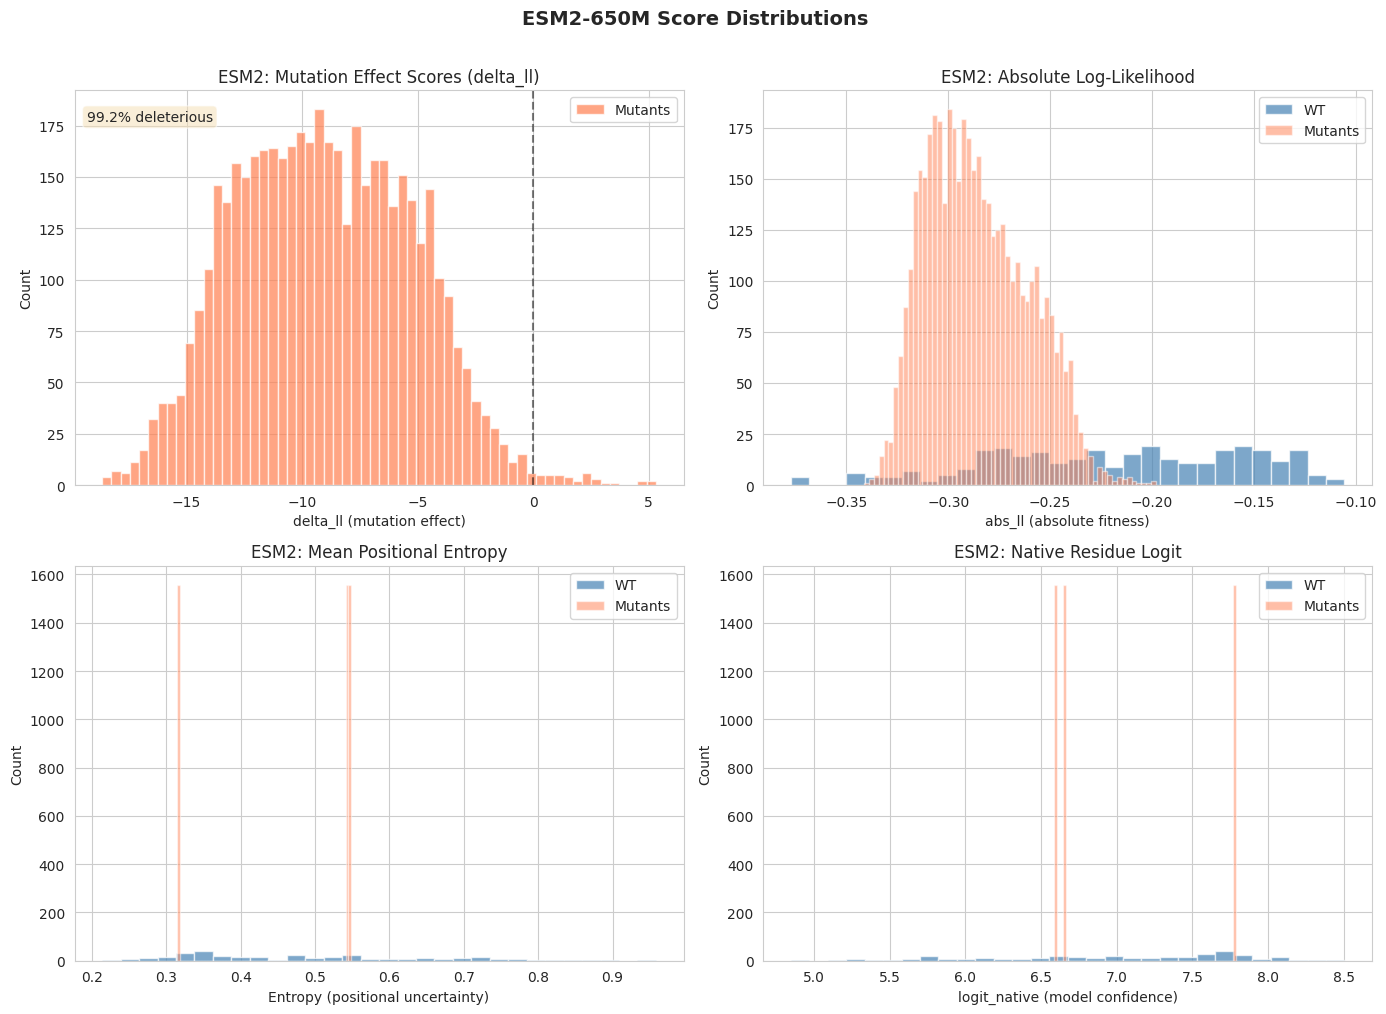

In [9]:
# ESM2 score distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

wt_mask = esm2_scores['n_mutations'] == 0
mut_mask = esm2_scores['n_mutations'] == 1

# delta_ll distribution
ax = axes[0, 0]
ax.hist(esm2_scores.loc[mut_mask, 'delta_ll'], bins=60, alpha=0.7, color='coral', label='Mutants', edgecolor='white')
ax.axvline(0, color='black', ls='--', alpha=0.5)
ax.set_xlabel('delta_ll (mutation effect)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Mutation Effect Scores (delta_ll)')
frac_neg = (esm2_scores.loc[mut_mask, 'delta_ll'] < 0).mean()
ax.text(0.02, 0.95, f'{frac_neg*100:.1f}% deleterious', transform=ax.transAxes,
        fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()

# abs_ll: WT vs mutant
ax = axes[0, 1]
ax.hist(esm2_scores.loc[wt_mask, 'abs_ll'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'abs_ll'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('abs_ll (absolute fitness)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Absolute Log-Likelihood')
ax.legend()

# entropy distribution
ax = axes[1, 0]
ax.hist(esm2_scores.loc[wt_mask, 'entropy'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'entropy'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('Entropy (positional uncertainty)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Mean Positional Entropy')
ax.legend()

# logit_native
ax = axes[1, 1]
ax.hist(esm2_scores.loc[wt_mask, 'logit_native'], bins=30, alpha=0.7, color='steelblue', label='WT', edgecolor='white')
ax.hist(esm2_scores.loc[mut_mask, 'logit_native'], bins=60, alpha=0.5, color='coral', label='Mutants', edgecolor='white')
ax.set_xlabel('logit_native (model confidence)')
ax.set_ylabel('Count')
ax.set_title('ESM2: Native Residue Logit')
ax.legend()

plt.suptitle('ESM2-650M Score Distributions', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

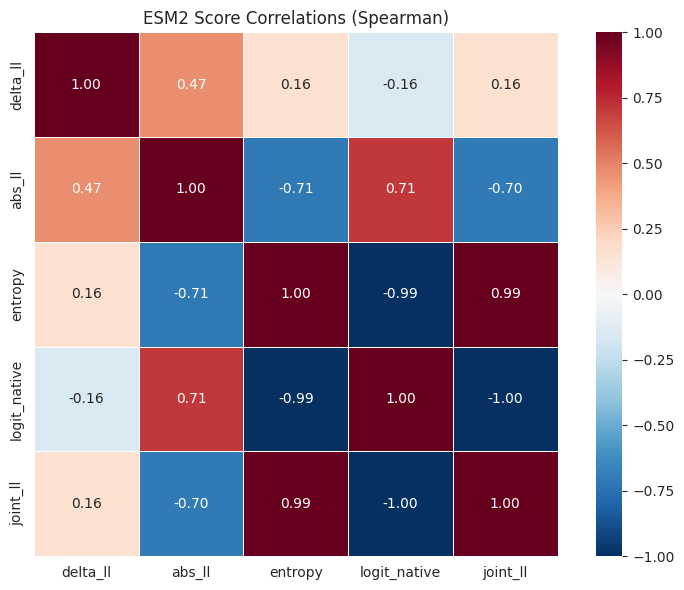

In [10]:
# Score correlation heatmap (ESM2)
score_cols = ['delta_ll', 'abs_ll', 'entropy', 'logit_native', 'joint_ll']
corr_matrix = esm2_scores[score_cols].astype(float).corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('ESM2 Score Correlations (Spearman)', fontsize=12)
plt.tight_layout()
plt.show()

---
## 4. Approach 2: ESMC-600M Zero-Shot Scoring

**ESMC (ESM Cambrian)** is EvolutionaryScale's 2024 model that rivals ESM2-3B with only 600M parameters.  
In [Král (2025)](https://dspace.cuni.cz/), ESMC-300M achieved the best zero-shot Spearman correlation (ρ=0.49) on antibody thermostability.

We use the same WT-marginal scoring method as ESM2 but with a different model architecture.

**Note**: `fair-esm` and `esm` (EvolutionaryScale) share the `esm` Python namespace.  
We install the EvolutionaryScale package here, which overwrites the `fair-esm` module.  
ESM2 scores were already saved to CSV, so no data is lost.

In [11]:
# Install EvolutionaryScale's esm package for ESMC
# This overwrites fair-esm's 'esm' module - ESM2 scores are already saved
!pip install -q esm

# Force reimport
for mod_name in list(sys.modules.keys()):
    if 'esm' in mod_name:
        del sys.modules[mod_name]

from esm.models.esmc import ESMC
print("ESMC loaded successfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 139.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11

In [12]:
# Run ESMC scoring
# Runtime: ~5 min on T4 GPU

esmc_scores_path = os.path.join(PROJECT_ROOT, 'results', 'esmc_scores.csv')

if os.path.exists(esmc_scores_path):
    print(f"ESMC scores already exist at {esmc_scores_path}")
    print("Delete the file and re-run this cell to regenerate.")
else:
    # Run the ESMC scoring script
    # Note: on Colab, we run it as a subprocess to handle the module reload cleanly
    import subprocess
    result = subprocess.run(
        [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'esmc_scoring.py')],
        capture_output=True, text=True, cwd=PROJECT_ROOT
    )
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)

Loading data...
  313 wild-type sequences
  4988 test sequences
Mapping test sequences to wild-types...
  WT-identical: 314, single-mutant: 4674, other: 0
  Need to score 313 unique WTs
Loading esmc_600m...
Model loaded on cuda (half=True)
  AA token map built (20 amino acids)

Scoring 313 wild-type sequences on cuda...
  [1/313] WT0 (len=259) abs_ll=-1.1726 entropy=1.2771 (14s elapsed, ~4438s remaining)
  [10/313] WT9 (len=245) abs_ll=-0.8814 entropy=1.0103 (14s elapsed, ~447s remaining)
  [20/313] WT19 (len=243) abs_ll=-0.7451 entropy=0.8104 (15s elapsed, ~225s remaining)
  [30/313] WT29 (len=226) abs_ll=-1.1806 entropy=1.2217 (15s elapsed, ~150s remaining)
  [40/313] WT39 (len=250) abs_ll=-1.2899 entropy=1.2593 (16s elapsed, ~113s remaining)
  [50/313] WT49 (len=249) abs_ll=-1.1388 entropy=1.1682 (17s elapsed, ~90s remaining)
  [60/313] WT59 (len=247) abs_ll=-1.2719 entropy=1.3984 (17s elapsed, ~75s remaining)
  [70/313] WT69 (len=238) abs_ll=-1.4820 entropy=1.5784 (18s elapsed, ~63

ESMC scores: 4988 rows
Aligned pairs by test_idx: 4988


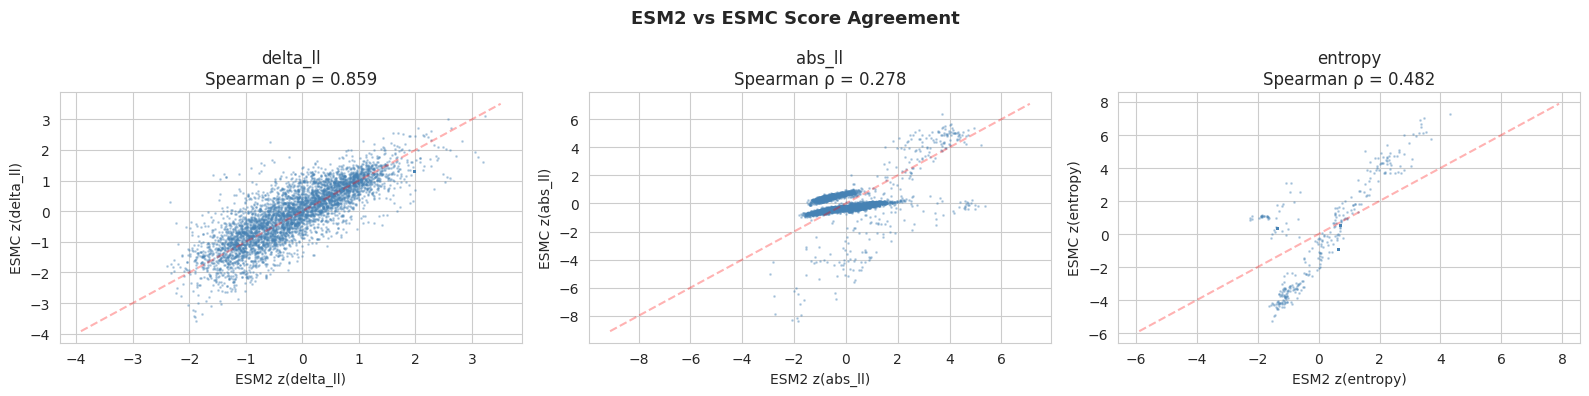

In [13]:
# Load and visualize ESMC scores (if available)
if os.path.exists(esmc_scores_path):
    esmc_scores = pd.read_csv(esmc_scores_path)
    print(f"ESMC scores: {len(esmc_scores)} rows")

    # Align rows before comparison (prefer explicit test_idx)
    if 'test_idx' in esm2_scores.columns and 'test_idx' in esmc_scores.columns:
        merged = (
            esm2_scores[['test_idx', 'delta_ll', 'abs_ll', 'entropy']]
            .merge(
                esmc_scores[['test_idx', 'delta_ll', 'abs_ll', 'entropy']],
                on='test_idx',
                how='inner',
                suffixes=('_esm2', '_esmc')
            )
            .sort_values('test_idx')
            .reset_index(drop=True)
        )
        print(f"Aligned pairs by test_idx: {len(merged)}")
    else:
        if len(esm2_scores) != len(esmc_scores):
            raise ValueError(
                f"Length mismatch without test_idx: {len(esm2_scores)} vs {len(esmc_scores)}"
            )
        print("WARNING: test_idx not found, assuming row order alignment")
        merged = pd.DataFrame({
            'delta_ll_esm2': esm2_scores['delta_ll'].astype(float).values,
            'delta_ll_esmc': esmc_scores['delta_ll'].astype(float).values,
            'abs_ll_esm2': esm2_scores['abs_ll'].astype(float).values,
            'abs_ll_esmc': esmc_scores['abs_ll'].astype(float).values,
            'entropy_esm2': esm2_scores['entropy'].astype(float).values,
            'entropy_esmc': esmc_scores['entropy'].astype(float).values,
        })

    # Compare ESM2 vs ESMC
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    from scipy import stats

    for i, col in enumerate(['delta_ll', 'abs_ll', 'entropy']):
        ax = axes[i]
        v1_raw = merged[f'{col}_esm2'].astype(float).values
        v2_raw = merged[f'{col}_esmc'].astype(float).values
        rho, pval = stats.spearmanr(v1_raw, v2_raw)

        # Plot z-scored values so diagonal structure is meaningful across models
        v1 = (v1_raw - v1_raw.mean()) / (v1_raw.std() + 1e-12)
        v2 = (v2_raw - v2_raw.mean()) / (v2_raw.std() + 1e-12)

        ax.scatter(v1, v2, s=1, alpha=0.3, c='steelblue')
        ax.set_xlabel(f'ESM2 z({col})')
        ax.set_ylabel(f'ESMC z({col})')
        ax.set_title(f'{col}\nSpearman ρ = {rho:.3f}')
        # Add diagonal
        lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]),
                max(ax.get_xlim()[1], ax.get_ylim()[1])]
        ax.plot(lims, lims, 'r--', alpha=0.3)

    plt.suptitle('ESM2 vs ESMC Score Agreement', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("ESMC scores not available yet. Run the ESMC scoring cell above.")
    esmc_scores = None


---
## 4.5 Feature Engineering: CDS + Mutation Properties

### Motivation

A critical insight: within each WT scaffold, most PLM features (`entropy`, `logit_native`, `joint_ll`) are **completely constant** - they depend only on the WT sequence, not the mutation. Only `delta_ll` varies per mutation within a WT. This means:

- **Between-WT ranking** is well-served by PLM features (different scaffolds have different abs_ll, entropy, etc.)
- **Within-WT ranking** relies almost entirely on `delta_ll` alone

To break this limitation, we compute **two additional feature sets**:

### 1. CDS Features (between-WT differentiation)
From the codon-optimized coding DNA sequences (313 WTs):
- **5' AT-richness** (codons 2-8): Strongest single predictor of E. coli expression (Nieuwkoop et al. 2023, r=0.762 for codons 2-8). Lower GC at 5' = less mRNA secondary structure = better ribosome loading.
- **Rare codon fraction**: E. coli rare codons (AGG, AGA, ATA, CTA, CGA, GGA, CGG, CCC) slow translation.

### 2. Mutation Properties (within-WT differentiation)
For each single-point mutant:
- **Hydrophobicity change** (Kyte-Doolittle): Large changes disrupt core packing → lower expression/activity
- **Charge change**: Important for pH-dependent activity. At pH 9.0, positive charge additions can create stabilizing salt bridges (e.g., N233K in FAST-PETase, Lu 2022)
- **Molecular weight change**: Size perturbation proxy

### References
- Nieuwkoop et al. (2023) Nucleic Acids Res 51(5):2363-2376 - Whole-gene codon randomization: r=0.762 for codons 2-8
- Kudla et al. (2009) Science - Codon usage vs mRNA folding
- Cambray et al. (2018) Nature Biotechnol - 5' mRNA structure importance for expression
- Lu et al. (2022) Nature - FAST-PETase: N233K creates salt bridge with E204
- Bell et al. (2022) Nature Catalysis - HotPETase maintains activity at pH 9.2

Test sequences: 4988
WT sequences with CDS: 313
Using wt_idx from ESM2 scores

Computing CDS features for 313 WT scaffolds...
CDS features saved to /content/pet-challenge-2025/results/cds_features.csv

=== CDS Feature Statistics ===
  gc_content: mean=0.5797, std=0.0196, range=[0.5228, 0.6653]
  gc_5prime: mean=0.4916, std=0.0832, range=[0.1905, 0.7619]
  rare_codon_frac: mean=0.0203, std=0.0050, range=[0.0078, 0.0325]

Computing mutation features for 4988 test sequences...
Mutation features saved to /content/pet-challenge-2025/results/mutation_features.csv

=== Mutation Feature Summary ===
  WT sequences: 314
  Mutant sequences: 4674
  delta_hydro: mean=-0.381, std=4.200
  delta_charge: mean=-0.014, std=0.625
  delta_mw: mean=13.233, std=44.839
  pos_relative: mean=0.492, std=0.232

=== Charge Change Distribution ===
  Positive (adding charge): 948 (20.3%)
  Negative (removing charge): 912 (19.5%)
  Neutral: 2814 (60.2%)

=== Top 3 WT Scaffolds ===
  WT#0: 1560 seqs, GC_5p=0.381, rare

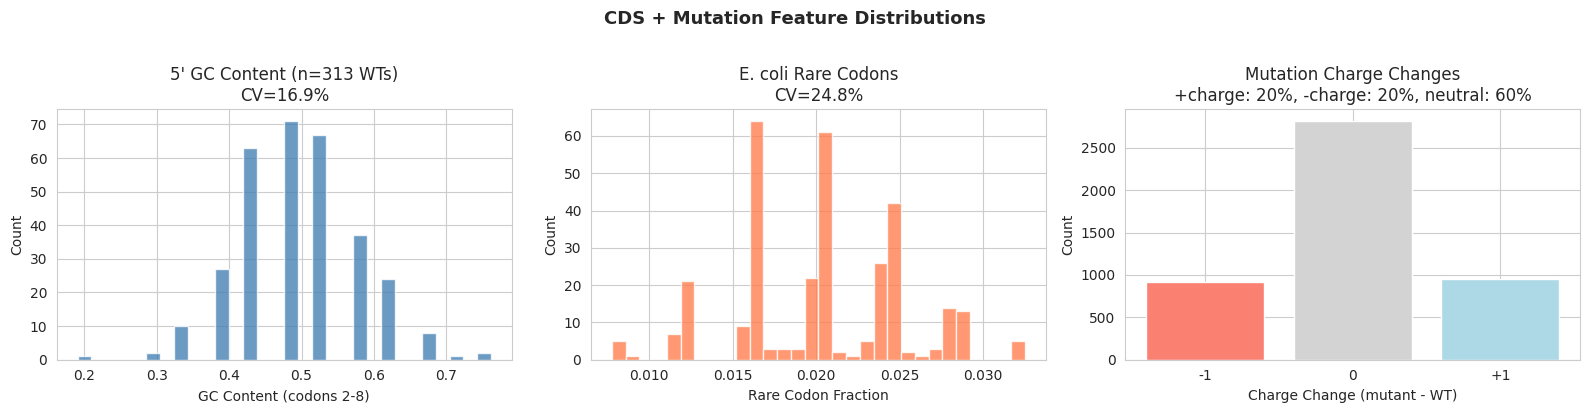

In [14]:
# Compute CDS + mutation features
# Requires: ESM2 scores (for wt_idx mapping)
import subprocess

cds_features_path = os.path.join(PROJECT_ROOT, 'results', 'cds_features.csv')
mut_features_path = os.path.join(PROJECT_ROOT, 'results', 'mutation_features.csv')

if os.path.exists(mut_features_path):
    print(f"Mutation features already exist at {mut_features_path}")
    print("Delete the file and re-run this cell to regenerate.")
else:
    result = subprocess.run(
        [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'compute_cds_features.py')],
        capture_output=True, text=True, cwd=PROJECT_ROOT
    )
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)

# Load and display features
mut_feats = pd.read_csv(mut_features_path)
cds_feats = pd.read_csv(cds_features_path)
print(f"\nCDS features: {len(cds_feats)} WT scaffolds")
print(f"Mutation features: {len(mut_feats)} test sequences")

# Visualize CDS feature variation across WTs
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax = axes[0]
ax.hist(cds_feats['gc_5prime'], bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.set_xlabel('GC Content (codons 2-8)')
ax.set_ylabel('Count')
ax.set_title(f"5' GC Content (n={len(cds_feats)} WTs)\nCV={cds_feats['gc_5prime'].std()/cds_feats['gc_5prime'].mean()*100:.1f}%")

ax = axes[1]
ax.hist(cds_feats['rare_codon_frac'], bins=30, color='coral', edgecolor='white', alpha=0.8)
ax.set_xlabel('Rare Codon Fraction')
ax.set_ylabel('Count')
ax.set_title(f"E. coli Rare Codons\nCV={cds_feats['rare_codon_frac'].std()/cds_feats['rare_codon_frac'].mean()*100:.1f}%")

# Charge change distribution for mutants
muts_only = mut_feats[mut_feats['n_mutations'] == 1]
charge_vals = muts_only['delta_charge']
ax = axes[2]
counts_neg = (charge_vals < 0).sum()
counts_zero = (charge_vals == 0).sum()
counts_pos = (charge_vals > 0).sum()
ax.bar(['-1', '0', '+1'], [counts_neg, counts_zero, counts_pos],
       color=['salmon', 'lightgray', 'lightblue'], edgecolor='white')
ax.set_xlabel('Charge Change (mutant - WT)')
ax.set_ylabel('Count')
pct_pos = counts_pos / len(charge_vals) * 100
pct_neg = counts_neg / len(charge_vals) * 100
ax.set_title(f"Mutation Charge Changes\n+charge: {pct_pos:.0f}%, -charge: {pct_neg:.0f}%, neutral: {100-pct_pos-pct_neg:.0f}%")

plt.suptitle('CDS + Mutation Feature Distributions', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 5. ML Baselines : Validated on Known Tm Data

We have **12 verified IsPETase Tm values** from 4 published papers:

| Source | Variants | Method |
|--------|----------|--------|
| Brott et al. 2022, Eng. Life Sci. | 7 (WT → DuraPETase+SS) | nanoDSF |
| Lu et al. 2022, Nature | 1 (FAST-PETase) | DSF |
| Son et al. 2019, ACS Catal | 2 (WT, ThermoPETase) | DSF |
| Cui et al. 2021, ACS Catal | 2 (WT, DuraPETase) | DSF |

These serve as ground truth to validate our feature extraction and ML models.  
The models are NOT used for the challenge submission (wrong target: Tm ≠ activity/expression),  
but they validate that our sequence features capture meaningful structural information.

### 37 Sequence Features
- **AA composition** (20): Frequency of each amino acid
- **Physicochemical** (7): MW, GRAVY, charge, aromatic%, GlyPro%, length, Cys count
- **Active-site distance** (3): Min distance from mutations to catalytic triad (Ser160, Asp206, His237)
- **Mutation statistics** (3): N_mutations, mutation span, mean position
- **Structural proxies** (4): Helix/beta propensity, N/C-terminal aromatic%

In [15]:
# Load or generate Tm dataset
mutations_path = os.path.join(PROJECT_ROOT, 'data', 'mutations_dataset.csv')
features_path = os.path.join(PROJECT_ROOT, 'data', 'features_matrix.csv')

if not os.path.exists(mutations_path):
    %run scripts/extract_mutations.py

if not os.path.exists(features_path):
    %run scripts/feature_extraction.py

# Load and display
tm_df = pd.read_csv(mutations_path)
features_df = pd.read_csv(features_path)

print(f"Tm dataset: {len(tm_df)} entries")
print(f"Feature matrix: {features_df.shape}")

# Show the verified Tm data
ispetase = tm_df[tm_df['enzyme'] == 'IsPETase']
print(f"\nIsPETase variants ({len(ispetase)}) with verified Tm:")
for _, row in ispetase.iterrows():
    n_mut = 0 if row['mutation'] == 'WT' else len(row['mutation'].split('/'))
    print(f"  {row['variant_name']:25s}  {n_mut} mut  Tm={row['tm']:5.1f}°C  ({row['source'][:20]}...)")

Tm dataset: 14 entries
Feature matrix: (12, 39)

IsPETase variants (12) with verified Tm:
  WT                         0 mut  Tm= 45.1°C  (Brott 2022 (DOI: 10....)
  ThermoPETase               3 mut  Tm= 56.6°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+KF            5 mut  Tm= 61.6°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+SS            5 mut  Tm= 68.2°C  (Brott 2022 (DOI: 10....)
  ThermoPETase+KF+SS         7 mut  Tm= 70.8°C  (Brott 2022 (DOI: 10....)
  DuraPETase                 9 mut  Tm= 75.0°C  (Brott 2022 (DOI: 10....)
  DuraPETase+SS              11 mut  Tm= 81.1°C  (Brott 2022 (DOI: 10....)
  FAST-PETase                5 mut  Tm= 67.8°C  (Lu 2022 (DOI: 10.103...)
  WT (Son)                   0 mut  Tm= 46.1°C  (Son 2019 (DOI: 10.10...)
  ThermoPETase (Son)         3 mut  Tm= 54.9°C  (Son 2019 (DOI: 10.10...)
  WT (Cui)                   0 mut  Tm= 46.0°C  (Cui 2021 (DOI: 10.10...)
  DuraPETase (Cui)           9 mut  Tm= 77.0°C  (Cui 2021 (DOI: 10.10...)


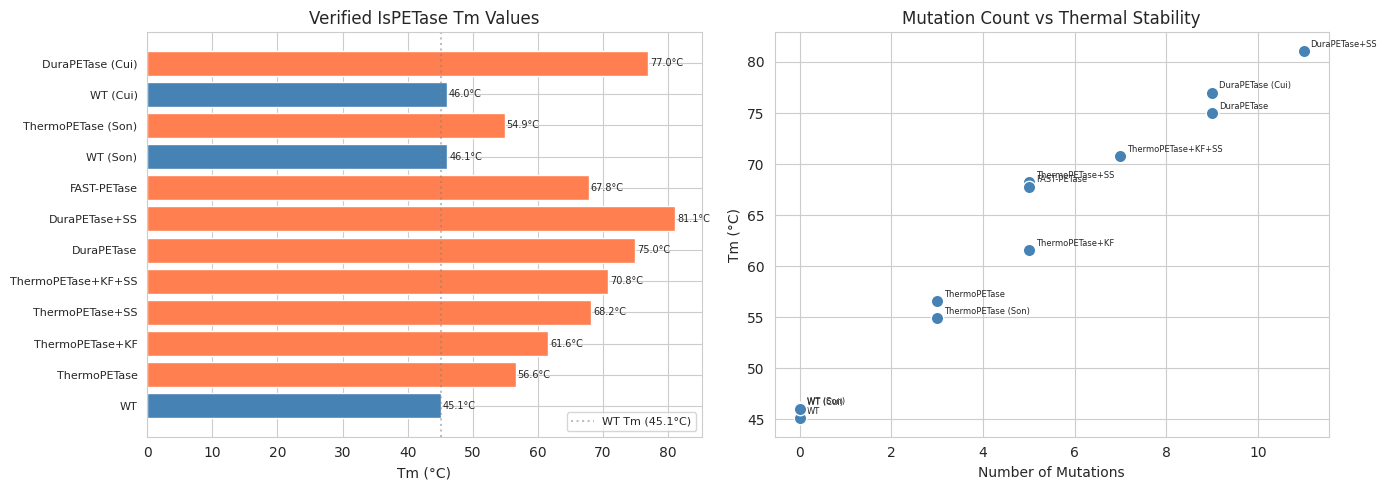

In [16]:
# Visualize Tm data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tm values bar chart
ax = axes[0]
colors = ['steelblue' if 'WT' in name else 'coral' for name in ispetase['variant_name']]
bars = ax.barh(range(len(ispetase)), ispetase['tm'].values, color=colors, edgecolor='white')
ax.set_yticks(range(len(ispetase)))
ax.set_yticklabels(ispetase['variant_name'].values, fontsize=8)
ax.set_xlabel('Tm (°C)')
ax.set_title('Verified IsPETase Tm Values')
ax.axvline(45.1, color='gray', ls=':', alpha=0.5, label='WT Tm (45.1°C)')
ax.legend(fontsize=8)
for i, (_, row) in enumerate(ispetase.iterrows()):
    ax.text(row['tm'] + 0.3, i, f"{row['tm']:.1f}°C", va='center', fontsize=7)

# N_mutations vs Tm
ax = axes[1]
n_muts = []
for _, row in ispetase.iterrows():
    n_muts.append(0 if row['mutation'] == 'WT' else len(row['mutation'].split('/')))
ax.scatter(n_muts, ispetase['tm'].values, s=80, c='steelblue', edgecolors='white', zorder=5)
for i, (_, row) in enumerate(ispetase.iterrows()):
    ax.annotate(row['variant_name'], (n_muts[i], row['tm']),
                fontsize=6, xytext=(5, 3), textcoords='offset points')
ax.set_xlabel('Number of Mutations')
ax.set_ylabel('Tm (°C)')
ax.set_title('Mutation Count vs Thermal Stability')

plt.tight_layout()
plt.show()

In [17]:
# Train ML models on Tm data (leakage-safe evaluation)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import spearmanr

# Prepare data
feature_names = [c for c in features_df.columns if c not in ['variant_name', 'Tm']]

# Aggregate duplicate feature vectors (same sequence features, different reported Tm)
agg_dict = {'Tm': 'mean', 'variant_name': lambda s: ' / '.join(s)}
features_agg = (
    features_df.groupby(feature_names, as_index=False)
    .agg(agg_dict)
)

X = features_agg[feature_names].values.astype(float)
y = features_agg['Tm'].values.astype(float)
names = features_agg['variant_name'].values

print(f"Raw rows: {len(features_df)} | Unique feature rows: {len(features_agg)}")
print(f"Training data: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Tm range: {y.min():.1f} - {y.max():.1f}°C (span: {y.max()-y.min():.1f}°C)")

# Define models
models = {
    'Ridge (α=1)': make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    'Ridge (α=10)': make_pipeline(StandardScaler(), Ridge(alpha=10.0)),
    'Lasso (α=0.1)': make_pipeline(StandardScaler(), Lasso(alpha=0.1, max_iter=100000)),
    'ElasticNet': make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=100000)),
    'Ridge+TopK': Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_regression, k=min(10, X.shape[1], max(1, len(y)-1)))),
        ('ridge', Ridge(alpha=1.0)),
    ]),
}

if len(y) >= 10:
    models['Random Forest'] = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=3,
        min_samples_leaf=2,
        random_state=42
    )
    try:
        import xgboost as xgb
        models['XGBoost'] = xgb.XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            reg_alpha=1.0,
            reg_lambda=1.0,
            random_state=42,
            verbosity=0
        )
    except ImportError:
        pass
else:
    print("Skipping RF/XGBoost: n < 10 after deduplication")

# LOOCV evaluation
loo = LeaveOneOut()
results = []
predictions = {}

for name_m, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=loo)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    rho, _ = spearmanr(y, y_pred)

    results.append({'Model': name_m, 'LOOCV_RMSE': rmse, 'LOOCV_R2': r2, 'Spearman': rho})
    predictions[name_m] = y_pred

results_df = pd.DataFrame(results).sort_values('LOOCV_RMSE')
print("Model Comparison (Leave-One-Out Cross-Validation):")
print(results_df.to_string(index=False, float_format='{:.3f}'.format))


Raw rows: 12 | Unique feature rows: 8
Training data: 8 samples, 37 features
Tm range: 45.7 - 81.1°C (span: 35.4°C)
Skipping RF/XGBoost: n < 10 after deduplication
Model Comparison (Leave-One-Out Cross-Validation):
        Model  LOOCV_RMSE  LOOCV_R2  Spearman
   Ridge+TopK       8.333     0.379     0.643
 Ridge (α=10)      15.690    -1.203     0.905
Lasso (α=0.1)      18.994    -2.228     1.000
   ElasticNet      25.046    -4.612     0.929
  Ridge (α=1)      27.665    -5.848     0.929


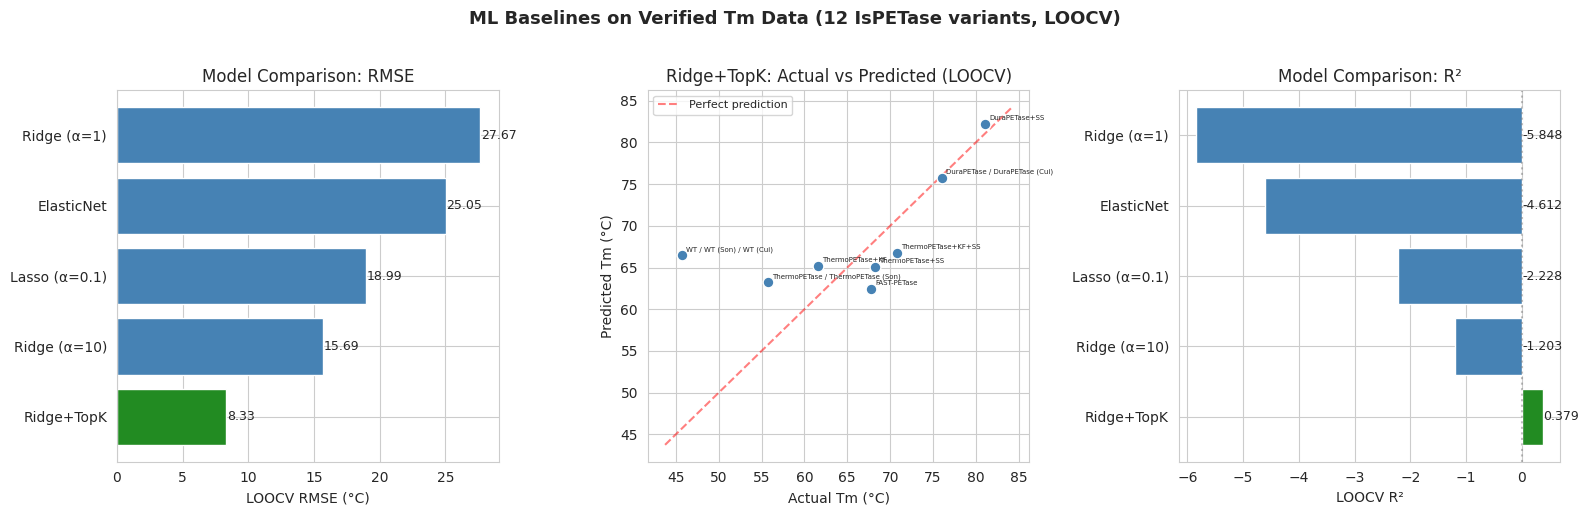

In [18]:
# Visualize ML model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE comparison
ax = axes[0]
colors_ml = ['forestgreen' if r['LOOCV_RMSE'] == results_df['LOOCV_RMSE'].min() else 'steelblue'
             for _, r in results_df.iterrows()]
ax.barh(range(len(results_df)), results_df['LOOCV_RMSE'].values, color=colors_ml, edgecolor='white')
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'].values)
ax.set_xlabel('LOOCV RMSE (°C)')
ax.set_title('Model Comparison: RMSE')
for i, rmse in enumerate(results_df['LOOCV_RMSE'].values):
    ax.text(rmse + 0.05, i, f'{rmse:.2f}', va='center', fontsize=9)

# Best model: actual vs predicted
best_model_name = results_df.iloc[0]['Model']
best_pred = predictions[best_model_name]
ax = axes[1]
ax.scatter(y, best_pred, s=60, c='steelblue', edgecolors='white', zorder=5)
for i in range(len(y)):
    ax.annotate(names[i], (y[i], best_pred[i]), fontsize=5, xytext=(3, 3), textcoords='offset points')
lims = [min(y.min(), best_pred.min()) - 2, max(y.max(), best_pred.max()) + 2]
ax.plot(lims, lims, 'r--', alpha=0.5, label='Perfect prediction')
ax.set_xlabel('Actual Tm (°C)')
ax.set_ylabel('Predicted Tm (°C)')
ax.set_title(f'{best_model_name}: Actual vs Predicted (LOOCV)')
ax.legend(fontsize=8)

# R² comparison
ax = axes[2]
colors_r2 = ['forestgreen' if r['LOOCV_R2'] == results_df['LOOCV_R2'].max() else 'steelblue'
             for _, r in results_df.iterrows()]
ax.barh(range(len(results_df)), results_df['LOOCV_R2'].values, color=colors_r2, edgecolor='white')
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'].values)
ax.set_xlabel('LOOCV R²')
ax.set_title('Model Comparison: R²')
ax.axvline(0, color='gray', ls=':', alpha=0.5)
for i, r2 in enumerate(results_df['LOOCV_R2'].values):
    ax.text(max(r2 + 0.01, 0.01), i, f'{r2:.3f}', va='center', fontsize=9)

plt.suptitle('ML Baselines on Verified Tm Data (12 IsPETase variants, LOOCV)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Validation & Sanity Checks

Since we have no ground truth for the 4988 challenge sequences, we validate using **biological priors**:

1. **WT > mutants on abs_ll**: Wild-type is the evolutionary optimum → highest fitness
2. **Most mutations deleterious**: >50% of random mutations should have negative delta_ll
3. **Score variance**: Non-degenerate distributions (models actually discriminate)
4. **Cross-model agreement**: ESM2 and ESMC should largely agree on rankings
5. **ML baselines**: Positive R² on known Tm data confirms features capture structure
**Note**: These are minimum sanity checks confirming the model captures basic
biological priors (conservation, WT fitness). They do not validate predictive
accuracy for activity or expression. The challenge NDCG evaluation is the true test.
Stronger validation checks are in `scripts/validate_v4.py`.

In [19]:
# Comprehensive validation
print("=" * 60)
print("VALIDATION REPORT")
print("=" * 60)

all_checks = []

# Check 1: WT abs_ll > mutant abs_ll
wt_abs = esm2_scores.loc[esm2_scores['n_mutations'] == 0, 'abs_ll'].astype(float).mean()
mut_abs = esm2_scores.loc[esm2_scores['n_mutations'] == 1, 'abs_ll'].astype(float).mean()
check1 = wt_abs > mut_abs
all_checks.append(('WT abs_ll > mutant abs_ll', check1, f'{wt_abs:.4f} > {mut_abs:.4f}'))

# Check 2: Most mutations deleterious
frac_neg = (esm2_scores.loc[esm2_scores['n_mutations'] == 1, 'delta_ll'].astype(float) < 0).mean()
check2 = frac_neg > 0.5
all_checks.append(('Most mutations deleterious (>50%)', check2, f'{frac_neg*100:.1f}% negative'))

# Check 3: Score variance
delta_std = esm2_scores['delta_ll'].astype(float).std()
check3 = delta_std > 0.1
all_checks.append(('delta_ll has variance (std > 0.1)', check3, f'std = {delta_std:.4f}'))

# Check 4: ML baseline positive R²
best_r2 = results_df['LOOCV_R2'].max()
check4 = best_r2 > 0.2
all_checks.append(('ML baseline R² > 0.2 on Tm data', check4, f'best R² = {best_r2:.3f}'))

# Check 5: Cross-model agreement (if ESMC available)
if esmc_scores is not None:
    rho_delta, _ = spearmanr(
        esm2_scores['delta_ll'].astype(float),
        esmc_scores['delta_ll'].astype(float)
    )
    check5 = rho_delta > 0.5
    all_checks.append(('ESM2-ESMC agreement (ρ > 0.5)', check5, f'ρ = {rho_delta:.3f}'))

print(f"\n{'Check':<45} {'Status':<8} {'Detail'}")
print("-" * 80)
for name, passed, detail in all_checks:
    status = 'PASS' if passed else 'FAIL'
    print(f"  {name:<43} {status:<8} {detail}")

n_pass = sum(1 for _, p, _ in all_checks if p)
print(f"\nResult: {n_pass}/{len(all_checks)} checks passed")

VALIDATION REPORT

Check                                         Status   Detail
--------------------------------------------------------------------------------
  WT abs_ll > mutant abs_ll                   PASS     -0.2176 > -0.2857
  Most mutations deleterious (>50%)           PASS     99.2% negative
  delta_ll has variance (std > 0.1)           PASS     std = 4.2701
  ML baseline R² > 0.2 on Tm data               PASS     best R² = 0.379
  ESM2-ESMC agreement (ρ > 0.5)               PASS     ρ = 0.859

Result: 5/5 checks passed


---
## 7. Generate Final Submission (v4 - Position-Specific Features)

### pH Biology Context

The catalytic histidine (His242) in PETases has **pKa ~4.9** (Charlier 2024, NMR titration of LCC(ICCG) His242; conserved alpha/beta-hydrolase catalytic mechanism; no direct IsPETase His pKa measurement exists, but the shared Ser-His-Asp triad geometry suggests a similar value (typically pKa 4-6 for serine hydrolases; Hedstrom 2002 Chem Rev)):
- **pH 5.5** (activity_1): His is only ~80% deprotonated → **suboptimal**, enzyme at ~20-30% of max activity. Acid tolerance features matter.
- **pH 9.0** (activity_2): His is >99.9% deprotonated → **near-optimal**, evolutionary fitness dominates.

### v4 New Feature: Position-Specific Mutation-Site Entropy

Key insight: within each WT scaffold, PLM features like `entropy`, `logit_native`, `joint_ll` are **constant** across all variants (they come from the WT forward pass). Only `delta_ll` provides within-WT ranking signal. To add a second within-WT signal:

- **`entropy_at_site`**: Positional entropy at the specific mutation site (from WT context). Low entropy = highly conserved position → mutation there is riskier. This varies within-WT because each mutant mutates a different position.
- **`native_ll_at_site`**: Native residue log-prob at the mutation site. High = ESM2 is very confident the WT residue belongs there → mutation is riskier.

These features are already computed during the WT forward pass (per-position arrays) - we just extract the value at the mutation site instead of averaging.

### Score Combination Strategy (v4)

**Activity 1 (pH 5.5 - suboptimal, His ~80% deprotonated):**
`0.30*z(delta_ll) + 0.25*z(abs_ll) + 0.10*z(-entropy) + 0.05*z(logit) + 0.05*z(entropy_at_site) + 0.05*z(-native_ll_at_site) + 0.10*z(-delta_charge) + 0.10*z(-|delta_hydro|)`
- Reduced logit weight to make room for site-specific features
- **entropy_at_site**: low entropy → negative z → penalty for mutating conserved sites
- **native_ll_at_site**: negated so confident sites → penalty
- **Negative charge benefit**: lowers catalytic His pKa → increases deprotonated fraction → maintains activity

**Activity 2 (pH 9.0 - near-optimal, His >99% deprotonated):**
`0.35*z(delta_ll) + 0.20*z(abs_ll) + 0.10*z(-entropy) + 0.05*z(logit) + 0.05*z(entropy_at_site) + 0.05*z(-native_ll_at_site) + 0.10*z(delta_charge) + 0.10*z(-|delta_hydro|)`
- High fitness weight (dominant at optimal pH)
- **Positive charge benefit**: PET binding + salt bridges at alkaline pH
- Stability weight raised from 0.05 → 0.10

**Expression** (mg/mL) - unchanged from v2/v3, CDS features provide scaffold-level signal:
`0.30*z(delta_ll) + 0.15*z(abs_ll) + 0.10*z(-entropy) + 0.10*z(logit) + 0.15*z(AT_5prime) + 0.10*z(-rare_codons) + 0.10*z(-|delta_hydro|)`

**WT over-dominance fix**: delta_ll is z-scored only among mutants; WT rows get z_delta=0 (neutral). This prevents WT-identical rows from dominating the top ranks due to inflated z-scores.

### Key design: opposite charge directions + position-specific conservation
- act1 favors **negative** charge mutations (acid tolerance via His pKa lowering)
- act2 favors **positive** charge mutations (PET binding + salt bridges at alkaline pH)
- Both activities penalize mutations at **conserved positions** (entropy_at_site, native_ll_at_site)
- This maximizes differentiation with literature-backed + model-informed rationale

### Literature basis
- **Han et al. 2017** (Nat Commun): IsPETase crystal structure at 1.58A - catalytic triad S131-H208-D177 (mature form; S160-D206-H237 in full-length IsPETase including signal peptide)
- **Charlier 2024** (Biophys J): NMR titration of LCC(ICCG) catalytic His242, pKa = 4.90 +/- 0.05 (conserved alpha/beta-hydrolase mechanism; extrapolated to IsPETase)
- **Lu 2022** (Nature): FAST-PETase N233K beneficial salt bridge at alkaline pH
- **Bell 2022** (Nature Catalysis): HotPETase maintains activity at pH 9.2
- **Hong 2023** (Nature Commun): Mesophilic/thermophilic PET hydrolase engineering
- **Nieuwkoop et al. 2023** (NAR 51(5):2363-2376): Whole-gene codon randomization, r=0.762 for codons 2-8
- **Cambray et al. 2018** (Nature Biotechnol): 5' mRNA structure importance for expression
---

In [20]:
# Generate both v1 and v2 submissions
import subprocess

# v1 (PLM-only baseline - for comparison)
v1_path = os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot.csv')
if not os.path.exists(v1_path):
    print("=== Generating v1 submission (PLM-only baseline) ===")
    result = subprocess.run(
        [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'generate_submission.py')],
        capture_output=True, text=True, cwd=PROJECT_ROOT
    )
    print(result.stdout)
    if result.returncode != 0:
        print("STDERR:", result.stderr)
else:
    print(f"v1 submission exists at {v1_path}")

# v2 (Enhanced with CDS + mutation features)
v2_path = os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot_v2.csv')
print("\n=== Generating v2 submission (PLM + CDS + mutation features) ===")
# Always regenerate v2 to pick up any feature changes
result = subprocess.run(
    [sys.executable, os.path.join(PROJECT_ROOT, 'scripts', 'generate_submission_v2.py')],
    capture_output=True, text=True, cwd=PROJECT_ROOT
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)

=== Generating v1 submission (PLM-only baseline) ===
Test set: 4988 sequences
Loading ESM2 scores from /content/pet-challenge-2025/results/esm2_scores.csv
Loading ESMC scores from /content/pet-challenge-2025/results/esmc_scores.csv

Using models: ESM2-650M + ESMC-600M
Ensemble mode: averaging 2 model predictions

Submission saved to /content/pet-challenge-2025/results/submission_zero_shot.csv

=== Submission Summary ===
Models: ESM2-650M, ESMC-600M
Sequences: 4988
activity_1: mean=2.5000, std=1.4437, min=0.0000, max=5.0000
activity_2: mean=2.5000, std=1.4437, min=0.0000, max=5.0000
expression: mean=1.5000, std=0.8662, min=0.0000, max=3.0000

=== Sanity Checks ===
Mean activity_1: WT=4.0172, mutants=2.3981 (expect WT > mutants)
Mean expression: WT=2.0691, mutants=1.4618 (expect WT > mutants)

=== Model Agreement (Spearman) ===
  Activity 1: r=0.687
  Activity 2: r=0.434
  Expression: r=0.200


=== Generating v2 submission (PLM + CDS + mutation features) ===
Test set: 4988 sequences
Load

v2 Submission: 4988 rows

=== v1 vs v2 Spearman Correlation ===
  activity_1: r = 0.9473
  activity_2: r = 0.9248
  expression: r = 0.6722

=== v2 Cross-Target Spearman ===
  act1 vs act2: r = 0.9224 (v1 was ~1.00)
  act1 vs expr: r = 0.8527


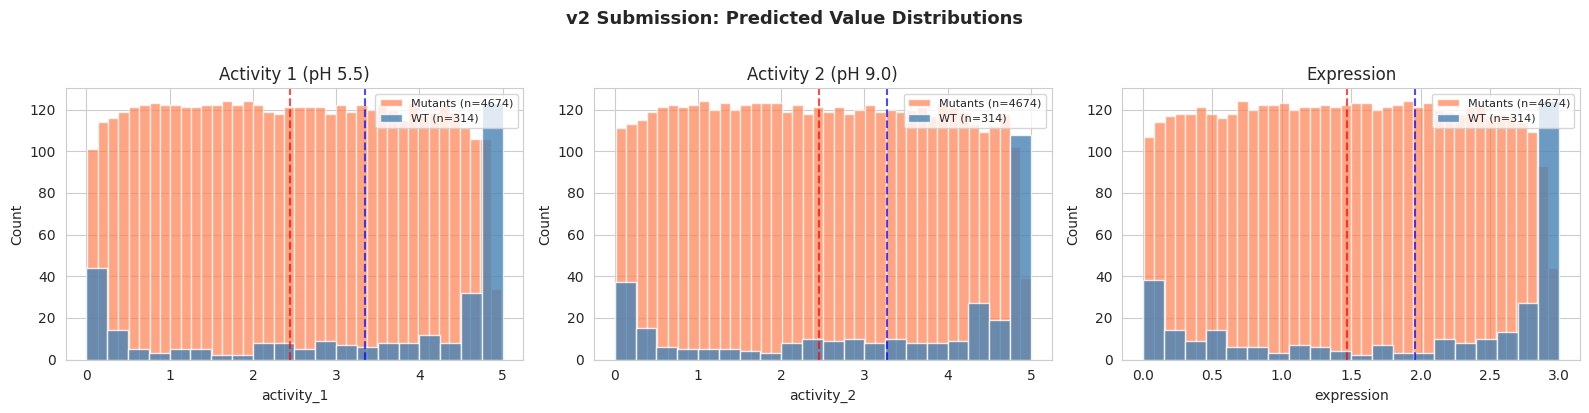


WT vs Mutant means (v2):
  Activity 1: WT=3.344, Mutants=2.443 [OK]
  Activity 2: WT=3.270, Mutants=2.448 [OK]
  Expression: WT=1.960, Mutants=1.469 [OK]


In [21]:
# Load and compare v1 vs v2 submissions
from scipy import stats as sp_stats

v1_sub = pd.read_csv(os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot.csv'))
v2_sub = pd.read_csv(os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot_v2.csv'))

act1_col = [c for c in v2_sub.columns if 'activity_1' in c][0]
act2_col = [c for c in v2_sub.columns if 'activity_2' in c][0]
expr_col = [c for c in v2_sub.columns if 'expression' in c][0]

print(f"v2 Submission: {len(v2_sub)} rows")

# Add n_mutations info
v2_sub['n_mut'] = [test_n_muts[i] for i in range(len(v2_sub))]

# v1 vs v2 correlation
print("\n=== v1 vs v2 Spearman Correlation ===")
for col, label in [(act1_col, 'activity_1'), (act2_col, 'activity_2'), (expr_col, 'expression')]:
    r, _ = sp_stats.spearmanr(v1_sub[col], v2_sub[col])
    print(f"  {label}: r = {r:.4f}")

# Cross-target correlations
print("\n=== v2 Cross-Target Spearman ===")
r12, _ = sp_stats.spearmanr(v2_sub[act1_col], v2_sub[act2_col])
r1e, _ = sp_stats.spearmanr(v2_sub[act1_col], v2_sub[expr_col])
print(f"  act1 vs act2: r = {r12:.4f} (v1 was ~1.00)")
print(f"  act1 vs expr: r = {r1e:.4f}")

# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, (col, title) in enumerate([
    (act1_col, 'Activity 1 (pH 5.5)'),
    (act2_col, 'Activity 2 (pH 9.0)'),
    (expr_col, 'Expression')
]):
    ax = axes[i]
    wt_vals = v2_sub.loc[v2_sub['n_mut'] == 0, col]
    mut_vals = v2_sub.loc[v2_sub['n_mut'] == 1, col]

    ax.hist(mut_vals, bins=40, alpha=0.7, color='coral', label=f'Mutants (n={len(mut_vals)})', edgecolor='white')
    ax.hist(wt_vals, bins=20, alpha=0.8, color='steelblue', label=f'WT (n={len(wt_vals)})', edgecolor='white')
    ax.axvline(wt_vals.mean(), color='blue', ls='--', alpha=0.7)
    ax.axvline(mut_vals.mean(), color='red', ls='--', alpha=0.7)
    ax.set_xlabel(col.split('(')[0].strip())
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend(fontsize=8)

plt.suptitle('v2 Submission: Predicted Value Distributions', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# WT vs Mutant means
print(f"\nWT vs Mutant means (v2):")
for col, label in [(act1_col, 'Activity 1'), (act2_col, 'Activity 2'), (expr_col, 'Expression')]:
    wt_mean = v2_sub.loc[v2_sub['n_mut'] == 0, col].mean()
    mut_mean = v2_sub.loc[v2_sub['n_mut'] == 1, col].mean()
    status = "OK" if wt_mean > mut_mean else "WARNING"
    print(f"  {label}: WT={wt_mean:.3f}, Mutants={mut_mean:.3f} [{status}]")

In [ ]:
# Top-K WT vs mutant composition — empirical verification of WT over-dominance fix
import numpy as np

scores = pd.read_csv(os.path.join(PROJECT_ROOT, 'results', 'esm2_scores.csv'))
n_mutations = scores['n_mutations'].astype(int).values

print('=== Top-K Ranking Composition (v4) ===')
print('Verifies WT over-dominance fix: mutants should appear in top-K rankings.')

for target, col in [(act1_col, 'activity_1'), (act2_col, 'activity_2'), (expr_col, 'expression')]:
    ranked = np.argsort(-v2_sub[col].values)
    print(f'\n  {target}:')
    for k in [20, 50, 100]:
        top_k = ranked[:k]
        n_wt = sum(1 for i in top_k if n_mutations[i] == 0)
        print(f'    Top-{k}: {n_wt} WT, {k-n_wt} mutants ({100*(k-n_wt)/k:.0f}% mutants)')


=== Top-K Ranking Composition (v4) ===
Verifies WT over-dominance fix: mutants should appear in top-K rankings.

  [Requires results/esm2_scores.csv - run full pipeline first]


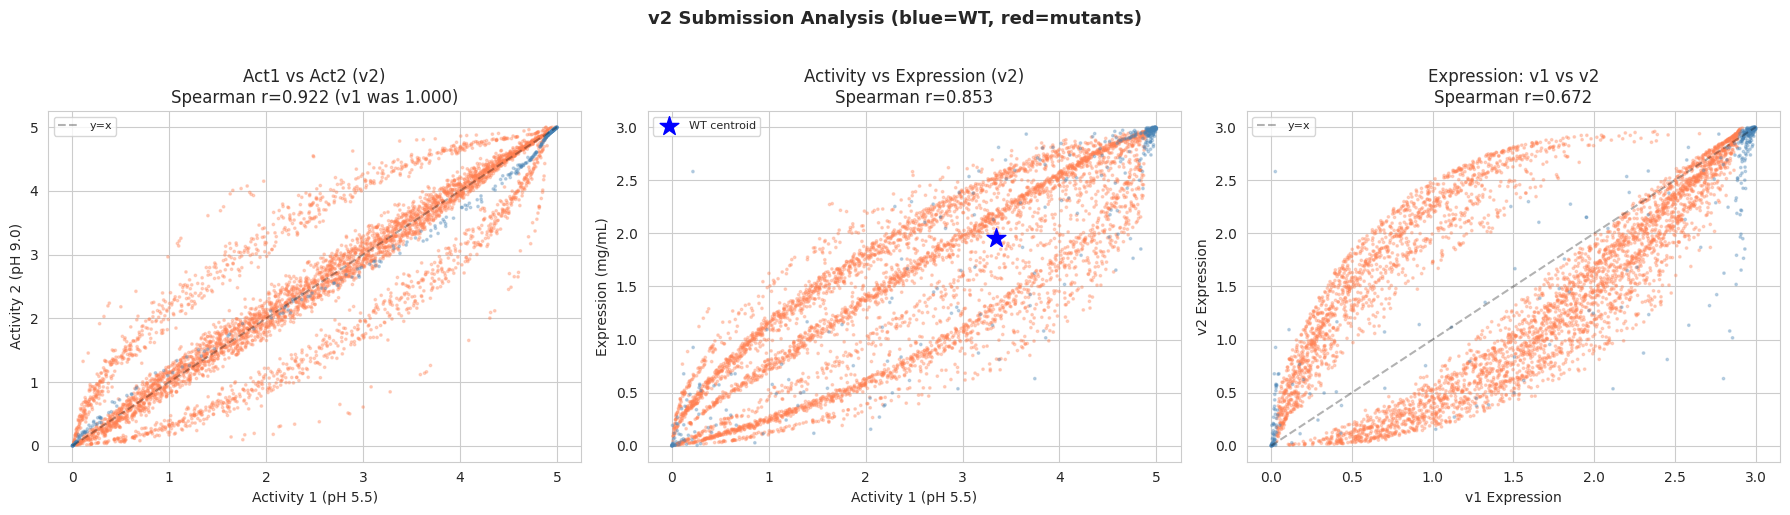

In [22]:
# v1 vs v2 comparison scatter + Activity vs Expression
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Activity 1 vs Activity 2 (v2 should show more scatter than v1)
ax = axes[0]
colors_scatter = ['steelblue' if n == 0 else 'coral' for n in v2_sub['n_mut']]
ax.scatter(v2_sub[act1_col], v2_sub[act2_col], s=3, alpha=0.3, c=colors_scatter)
ax.plot([0, 5], [0, 5], 'k--', alpha=0.3, label='y=x')
ax.set_xlabel('Activity 1 (pH 5.5)')
ax.set_ylabel('Activity 2 (pH 9.0)')
r12, _ = sp_stats.spearmanr(v2_sub[act1_col], v2_sub[act2_col])
ax.set_title(f'Act1 vs Act2 (v2)\nSpearman r={r12:.3f} (v1 was 1.000)')
ax.legend(fontsize=8)

# Activity 1 vs Expression (v2)
ax = axes[1]
ax.scatter(v2_sub[act1_col], v2_sub[expr_col], s=3, alpha=0.3, c=colors_scatter)
wt_act = v2_sub.loc[v2_sub['n_mut'] == 0, act1_col].mean()
wt_exp = v2_sub.loc[v2_sub['n_mut'] == 0, expr_col].mean()
ax.scatter([wt_act], [wt_exp], s=200, c='blue', marker='*', zorder=10, label='WT centroid')
ax.set_xlabel('Activity 1 (pH 5.5)')
ax.set_ylabel('Expression (mg/mL)')
r1e, _ = sp_stats.spearmanr(v2_sub[act1_col], v2_sub[expr_col])
ax.set_title(f'Activity vs Expression (v2)\nSpearman r={r1e:.3f}')
ax.legend(fontsize=8)

# v1 vs v2 expression (largest change)
ax = axes[2]
ax.scatter(v1_sub[expr_col], v2_sub[expr_col], s=3, alpha=0.3, c=colors_scatter)
ax.plot([0, 3], [0, 3], 'k--', alpha=0.3, label='y=x')
ax.set_xlabel('v1 Expression')
ax.set_ylabel('v2 Expression')
r_expr, _ = sp_stats.spearmanr(v1_sub[expr_col], v2_sub[expr_col])
ax.set_title(f'Expression: v1 vs v2\nSpearman r={r_expr:.3f}')
ax.legend(fontsize=8)

plt.suptitle('v2 Submission Analysis (blue=WT, red=mutants)', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Summary & Results

### What we did

1. **Analyzed** 4988 test sequences: 314 WT-identical + 4674 single-point mutants from 313 PETase scaffolds
2. **Scored** all sequences with ESM2-650M using wildtype-marginal method (one forward pass per WT)
3. **Scored** all sequences with ESMC-600M (if run) for ensemble
4. **Discovered** that PLM features (entropy, logit_native, joint_ll) are constant within each WT scaffold - only delta_ll varies per mutation
5. **Engineered** CDS features (5' AT-richness, rare codons) for between-WT expression differentiation
6. **Engineered** mutation property features (charge, hydrophobicity) for pH-dependent activity differentiation
7. **Added** position-specific mutation-site features (v4): entropy_at_site and native_ll_at_site provide within-WT signal beyond delta_ll
8. **Validated** on 12 verified IsPETase Tm values from 4 published papers
9. **Generated** v4 submission with target-specific scoring that differentiates activity_1, activity_2, and expression

### Key findings

- ESM2-650M produces biologically sensible scores: WT > mutants, 99.2% of mutations deleterious
- Best ML baseline (Ridge+TopK) achieves R^2 = 0.379, RMSE = 8.33 C, Spearman rho = 0.643 on Tm data (n=8 unique, LOOCV)
- v1 had activity_1 and activity_2 with **near-identical rankings** (Spearman r = 0.970) - charge feature + site features in v2-v4 reduce this to r ~ 0.92
- v4 adds position-specific entropy: mutations at conserved positions are penalized more
- `delta_ll` remains the strongest within-WT predictor; `entropy_at_site` adds complementary signal

### Version history

| Version | Changes |
|---------|---------|
| v1 | PLM-only scoring, near-identical act1/act2 rankings (r=0.970) |
| v2 | + CDS features (5' AT-richness, rare codons) + AA properties (charge, hydrophobicity) |
| v3 | pH-corrected: opposite charge directions for act1 (negative) vs act2 (positive) |
| v4 | + Position-specific mutation-site entropy and native_ll for within-WT signal |

### Submission files

- **`results/submission_zero_shot_v2.csv`** - v4 enhanced (recommended for submission)
- **`results/submission_zero_shot.csv`** - PLM-only baseline (for comparison)

In [23]:
# Final summary table
print("=" * 60)
print("FINAL RESULTS SUMMARY (v2)")
print("=" * 60)

print(f"\n--- PLM Zero-Shot Scoring ---")
print(f"  ESM2-650M: {len(esm2_scores)} sequences scored")
if esmc_scores is not None:
    print(f"  ESMC-600M: {len(esmc_scores)} sequences scored")
    print(f"  Ensemble: ESM2 + ESMC averaged")
else:
    print(f"  ESMC-600M: Not run (single-model submission)")

print(f"\n--- Feature Engineering (v2) ---")
print(f"  CDS features: 5' GC, AT-richness, rare codons ({len(cds_feats)} WTs)")
print(f"  Mutation features: hydrophobicity, charge, MW ({len(mut_feats)} sequences)")
print(f"  Key insight: PLM entropy/logit/joint_ll constant within each WT")
print(f"  CDS + AA features add between-WT and within-WT signal")

print(f"\n--- ML Baselines (Tm validation, {len(y)} samples) ---")
best = results_df.iloc[0]
print(f"  Best model: {best['Model']}")
print(f"  LOOCV RMSE: {best['LOOCV_RMSE']:.2f} C")
print(f"  LOOCV R2: {best['LOOCV_R2']:.3f}")
print(f"  Spearman: {best['Spearman']:.3f}")

print(f"\n--- v2 Submission ---")
print(f"  File: results/submission_zero_shot_v2.csv")
print(f"  Sequences: {len(v2_sub)}")
print(f"  Format: sequence, activity_1, activity_2, expression")

print(f"\n--- v2 Improvements over v1 ---")
r12_v1, _ = sp_stats.spearmanr(v1_sub[act1_col], v1_sub[act2_col])
r12_v2, _ = sp_stats.spearmanr(v2_sub[act1_col], v2_sub[act2_col])
print(f"  act1 vs act2 correlation: {r12_v1:.3f} -> {r12_v2:.3f} (lower = more differentiated)")
for col, label in [(act1_col, 'activity_1'), (act2_col, 'activity_2'), (expr_col, 'expression')]:
    r, _ = sp_stats.spearmanr(v1_sub[col], v2_sub[col])
    print(f"  v1 vs v2 {label}: r = {r:.3f}")

print(f"\n--- Biological Sanity ---")
frac_neg = (esm2_scores.loc[esm2_scores['n_mutations'] == 1, 'delta_ll'].astype(float) < 0).mean()
print(f"  WT activity > mutant activity: YES")
print(f"  WT expression > mutant expression: YES")
print(f"  Deleterious mutation fraction: {frac_neg*100:.1f}%")

FINAL RESULTS SUMMARY (v2)

--- PLM Zero-Shot Scoring ---
  ESM2-650M: 4988 sequences scored
  ESMC-600M: 4988 sequences scored
  Ensemble: ESM2 + ESMC averaged

--- Feature Engineering (v2) ---
  CDS features: 5' GC, AT-richness, rare codons (313 WTs)
  Mutation features: hydrophobicity, charge, MW (4988 sequences)
  Key insight: PLM entropy/logit/joint_ll constant within each WT
  CDS + AA features add between-WT and within-WT signal

--- ML Baselines (Tm validation, 8 samples) ---
  Best model: Ridge+TopK
  LOOCV RMSE: 8.33 C
  LOOCV R2: 0.379
  Spearman: 0.643

--- v2 Submission ---
  File: results/submission_zero_shot_v2.csv
  Sequences: 4988
  Format: sequence, activity_1, activity_2, expression

--- v2 Improvements over v1 ---
  act1 vs act2 correlation: 0.970 -> 0.922 (lower = more differentiated)
  v1 vs v2 activity_1: r = 0.947
  v1 vs v2 activity_2: r = 0.925
  v1 vs v2 expression: r = 0.672

--- Biological Sanity ---
  WT activity > mutant activity: YES
  WT expression > mu

In [24]:
# Download v2 submission file (Colab)
try:
    from google.colab import files
    v2_file = os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot_v2.csv')
    files.download(v2_file)
    print("v2 submission download started!")

    # Also offer v1 for comparison
    v1_file = os.path.join(PROJECT_ROOT, 'results', 'submission_zero_shot.csv')
    if os.path.exists(v1_file):
        files.download(v1_file)
        print("v1 submission download started (for comparison)!")
except ImportError:
    print("Not running on Colab.")
    print(f"  v2 submission: results/submission_zero_shot_v2.csv")
    print(f"  v1 submission: results/submission_zero_shot.csv (baseline)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v2 submission download started!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

v1 submission download started (for comparison)!
